In [70]:
import pandas as pd
import os
import numpy as np

In [281]:
from catboost import CatBoostClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score

In [283]:
x = pd.read_csv(r'../data/interim/xinit.csv')
y = pd.read_csv(r'../data/interim/yinit.csv')

x['bmi'] = (x['Weight'] / x['Height'] ** 2)

#x = x.drop('Weight', axis=1)

In [285]:
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in x.columns if x[cname].nunique() < 8 and x[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in x.columns if x[cname].dtype in ['int64', 'float64']]

In [287]:
categorical_cols

['Gender', 'family_history_with_overweight', 'CAEC', 'CALC']

In [289]:
numerical_cols

['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'bmi']

In [291]:
#create numerical transformer
numerical_transformer = Pipeline([('imputer', SimpleImputer(strategy='mean')), 
                                  ('scaler', StandardScaler()) ])

#create categorical transformer
categorical_transformer = Pipeline(steps=[ ('imputer', SimpleImputer(strategy='most_frequent')),
                                            ('onehot', OneHotEncoder(handle_unknown='ignore'))
                                            ])

In [295]:
preprocessor = ColumnTransformer(
                                transformers=[
                                    ('num', numerical_transformer, numerical_cols),
                                    ('cat', categorical_transformer, categorical_cols)
    ])

In [297]:
X_train = pd.read_csv(r'../data/interim/x_train_init.csv')
X_test = pd.read_csv(r'../data/interim/x_test_init.csv')
y_train = pd.read_csv(r'../data/interim/y_train_init.csv')
y_test = pd.read_csv(r'../data/interim/y_test_init.csv')

In [299]:
X_train['bmi'] = (X_train['Weight'] / X_train['Height'] ** 2)
X_test['bmi'] = (X_test['Weight'] / X_test['Height'] ** 2)
#X_train = X_train.drop('Weight', axis=1)
#X_test = X_test.drop('Weight', axis=1)

In [301]:
# Create a CatBoostClassifier model
cb = CatBoostClassifier(
    iterations=300,        # Equivalent to n_estimators
    learning_rate=0.1,
    depth=5,
    random_state=42,
    verbose=0               # Suppress training output
)

# Model pipeline
# Create pipeline
rf_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('catboost', cb)
])

# Preprocessing of training data, fit model 
rf_pipe.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
rf_preds = rf_pipe.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, rf_preds)
print('Accuracy for Catboost:', accuracy)

# Detailed classification report
print('Classification Report:\n', classification_report(y_test, rf_preds))


Accuracy for Catboost: 0.8953114964675658
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93       755
           1       0.86      0.88      0.87       907
           2       0.75      0.78      0.77       733
           3       0.79      0.77      0.78       763
           4       0.89      0.86      0.87       858
           5       0.97      0.98      0.97      1005
           6       1.00      1.00      1.00      1207

    accuracy                           0.90      6228
   macro avg       0.88      0.88      0.88      6228
weighted avg       0.90      0.90      0.90      6228



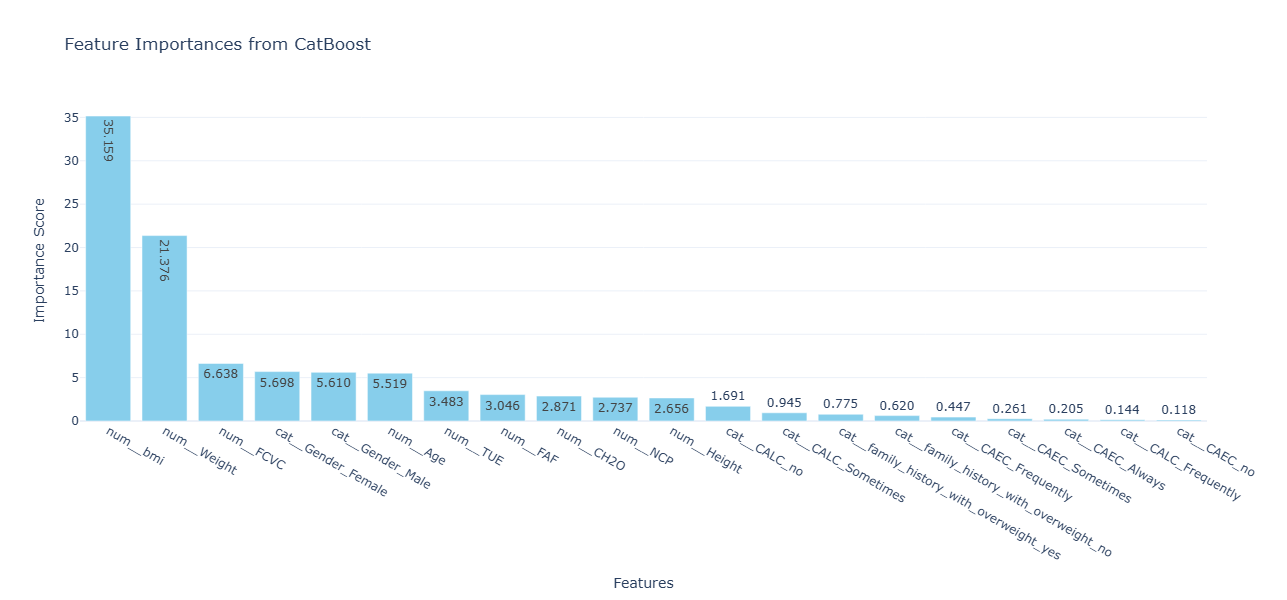

In [303]:
import plotly.graph_objects as go
# Get feature names from the preprocessor
feature_names = preprocessor.get_feature_names_out()


importances = cb.feature_importances_

# Get the feature importances from the Random Forest model
# Create a dictionary mapping feature names to their importances
feature_importance_dict = dict(zip(feature_names, importances))

# Optional: Sort the dictionary by importance in descending order
feature_importance_sorted = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))

fig = go.Figure(data=[
        go.Bar(
            x=list(feature_importance_sorted.keys()),
            y=list(feature_importance_sorted.values()),
            marker=dict(color='skyblue'),
            text=[f"{v:.3f}" for v in feature_importance_sorted.values()],
            textposition='auto'
        )
    ])

# Update layout for better aesthetics
fig.update_layout(
    title='Feature Importances from CatBoost',
    xaxis_title='Features',
    yaxis_title="Importance Score",
    template='plotly_white',
    height=600
)

# Display the figure
fig.show()

In [305]:
crv_scores_cb = cross_val_score(rf_pipe, x, y,
                                cv=5,
                                scoring='accuracy')

print("Accuracy from Cross Validation (CatBoost):", crv_scores_cb)
print("Mean Accuracy:", crv_scores_cb.mean())
print("Standard Deviation:", crv_scores_cb.std())

Accuracy from Cross Validation (CatBoost): [0.89402697 0.89258189 0.90317919 0.90195134 0.90363768]
Mean Accuracy: 0.8990754137290317
Standard Deviation: 0.004766104912685802


In [307]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Define the hyperparameter space for CatBoost
param_dist = {
    'catboost__iterations': randint(100, 500),            # Number of trees
    'catboost__learning_rate': uniform(0.01, 0.29),       # Learning rate between 0.01 and 0.3
    'catboost__depth': randint(3, 10),                    # Depth of trees
    'catboost__l2_leaf_reg': uniform(1, 10),              # L2 regularization term
    'catboost__border_count': randint(32, 255),           # Number of splits for numerical features
    'catboost__bagging_temperature': uniform(0, 1),       # Controls the intensity of Bayesian bagging
    'catboost__random_strength': uniform(1, 10),          # Standard deviation of the Gaussian prior on weights
    'catboost__od_type': ['IncToDec', 'Iter', 'IterWithoutNeighbors'],  # Overfitting detector types
    'catboost__od_wait': randint(10, 50)                  # Number of iterations to wait for improvement
}


In [309]:
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_pipe,               # The pipeline to optimize
    param_distributions=param_dist,  # The hyperparameter space
    n_iter=30,                        # Number of parameter settings sampled
    cv=5,                             # 5-fold cross-validation
    scoring='accuracy',               # Evaluation metric
    random_state=42,                  # Ensures reproducibility
    n_jobs=-1,                        # Use all available cores
    verbose=1                         # Displays progress
)

# Perform the random search on the training data
random_search.fit(X_train, y_train)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning:


55 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
55 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 475, in

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Age',
                                                                                'Height',
                                                                                'Weight',
                                                                                'FCVC',
                                                                                'NCP',
                                                                                'CH2O',
                                                                                'FAF',
                                                                                'TUE',
                                                                                'bmi']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehot',
                                                                                                OneHotEncoder(handle_...
                                        'catboost__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000026E20406360>,
                                        'catboost__od_type': ['IncToDec',
                                                              'Iter',
                                                              'IterWithoutNeighbors'],
                                        'catboost__od_wait': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000026E20404050>,
                                        'catboost__random_strength': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000026E20405460>},
                   random_state=42, scoring='accuracy', verbose=1)

In [117]:
# Best hyperparameters
print("Best Hyperparameters:\n", random_search.best_params_)

# Best cross-validation score
print("Best Cross-Validation Accuracy:", random_search.best_score_)

# Evaluate the best model on the test set
best_model = random_search.best_estimator_

# Make predictions
best_preds = best_model.predict(X_test)

# Calculate accuracy
best_accuracy = accuracy_score(y_test, best_preds)
print('Test Set Accuracy for Best CatBoost Model:', best_accuracy)

# Detailed classification report
print('Classification Report for Best CatBoost Model:\n', classification_report(y_test, best_preds))


Best Hyperparameters:
 {'catboost__bagging_temperature': 0.21233911067827616, 'catboost__border_count': 223, 'catboost__depth': 6, 'catboost__iterations': 376, 'catboost__l2_leaf_reg': 7.1748150962771655, 'catboost__learning_rate': 0.18737941654160145, 'catboost__od_type': 'IncToDec', 'catboost__od_wait': 34, 'catboost__random_strength': 3.9122914019804194}
Best Cross-Validation Accuracy: 0.9015830209224763
Test Set Accuracy for Best CatBoost Model: 0.9006101477199743
Classification Report for Best CatBoost Model:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94       755
           1       0.88      0.89      0.89       907
           2       0.77      0.78      0.77       733
           3       0.79      0.78      0.78       763
           4       0.88      0.87      0.87       858
           5       0.97      0.98      0.97      1005
           6       1.00      1.00      1.00      1207

    accuracy                           0.90  